In [1]:
import os
import numpy as np
import torch
import time
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.autograd import Variable
from pathlib import Path

%matplotlib inline

In [2]:
#importing the training options
os.chdir("../")
import config.train_opt as opt

In [3]:
pix2pixhd_dir = Path('./src/pix2pixHD/')

import sys
sys.path.append(str(pix2pixhd_dir))
%load_ext autoreload
%autoreload 2


In [4]:
# from options.train_options import TrainOptions
from data.data_loader import CreateDataLoader
from models.models import create_model
import util.util as util
from util.visualizer import Visualizer

In [5]:
# with open('./config/train_opt.pkl', mode='rb') as f:
#     opt = pickle.load(f)

# opt.dataroot = "./dataset"
# #Was 18 before
# opt.label_nc = 0
# opt.fp16 = False
# opt.name="Pose_Game"
# opt.checkpoints_dir = "./checkpoints/"

iter_path = os.path.join(opt.checkpoints_dir, opt.name, 'iter.txt')

In [8]:
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()
dataset_size = len(data_loader)
print('#training images = %d' % dataset_size)
    
start_epoch, epoch_iter = 1, 0
total_steps = (start_epoch-1) * dataset_size + epoch_iter
display_delta = total_steps % opt.display_freq
print_delta = total_steps % opt.print_freq
save_delta = total_steps % opt.save_latest_freq

CustomDatasetDataLoader
dataset [AlignedDataset] was created
#training images = 26000


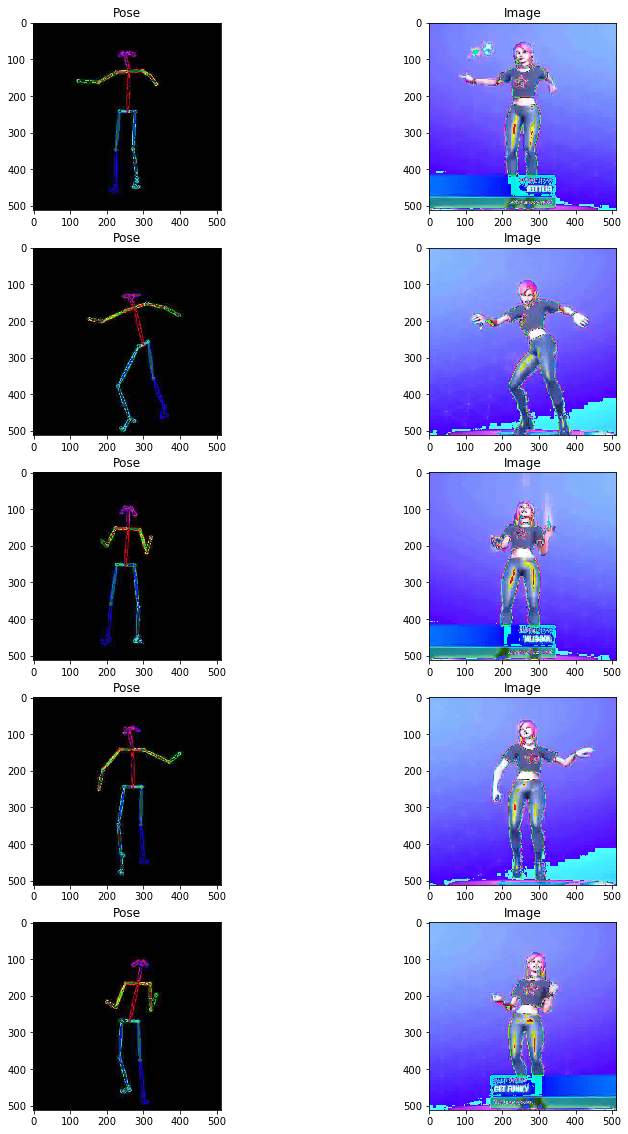

In [9]:
#For Visualization purposes
fig = plt.figure(figsize = [13,20])
for i,temp in enumerate(dataset):
    #Pose
    plt.subplot(5,2,i*2+1)
    plt.title("Pose")
    plt.imshow(temp['label'][0].permute(1,2,0))
    #Image
    plt.subplot(5,2,(i+1)*2)
    plt.title("Image")
    plt.imshow(temp['image'][0].permute(1,2,0))

    if i==4:
        break
plt.show()

In [10]:
model = create_model(opt)
visualizer = Visualizer(opt)

GlobalGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affi

create web directory ./checkpoints/Pose_Game/web...


In [14]:
for epoch in range(start_epoch, opt.niter + opt.niter_decay + 1):
    epoch_start_time = time.time()
    if epoch != start_epoch:
        epoch_iter = epoch_iter % dataset_size
    for i, data in enumerate(dataset, start=epoch_iter):
        iter_start_time = time.time()
        total_steps += opt.batchSize
        epoch_iter += opt.batchSize

        # whether to collect output images
        save_fake = total_steps % opt.display_freq == display_delta
        
        ############## Forward Pass ######################
        losses, generated = model(Variable(data['label']), Variable(data['inst']), 
            Variable(data['image']), Variable(data['feat']), infer=save_fake)
        
        # sum per device losses
        losses = [ torch.mean(x) if not isinstance(x, int) else x for x in losses ]
        loss_dict = dict(zip(model.module.loss_names, losses))

        # calculate final loss scalar
        loss_D = (loss_dict['D_fake'] + loss_dict['D_real']) * 0.5
        loss_G = loss_dict['G_GAN'] + loss_dict.get('G_GAN_Feat',0) + loss_dict.get('G_VGG',0)
        
        ############### Backward Pass ####################
        # update generator weights
        model.module.optimizer_G.zero_grad()
        loss_G.backward()
        model.module.optimizer_G.step()

        # update discriminator weights
        model.module.optimizer_D.zero_grad()
        loss_D.backward()
        model.module.optimizer_D.step()
        
        #call(["nvidia-smi", "--format=csv", "--query-gpu=memory.used,memory.free"]) 

        ############## Display results and errors ##########
        ### print out errors
        if total_steps % opt.print_freq == print_delta:
#             errors = {k: v.data[0] if not isinstance(v, int) else v for k, v in loss_dict.items()}
            errors = {k: v.item() if not isinstance(v, int) else v for k, v in loss_dict.items()}
            t = (time.time() - iter_start_time) / opt.batchSize
            visualizer.print_current_errors(epoch, epoch_iter, errors, t)
            visualizer.plot_current_errors(errors, total_steps)

        ### display output images
        if save_fake:
            visuals = OrderedDict([('input_label', util.tensor2label(data['label'][0], opt.label_nc)),
                                   ('synthesized_image', util.tensor2im(generated.data[0])),
                                   ('real_image', util.tensor2im(data['image'][0]))])
            visualizer.display_current_results(visuals, epoch, total_steps)

        ### save latest model
        if total_steps % opt.save_latest_freq == save_delta:
            print('saving the latest model (epoch %d, total_steps %d)' % (epoch, total_steps))
            model.module.save('latest')            
            np.savetxt(iter_path, (epoch, epoch_iter), delimiter=',', fmt='%d')

        if epoch_iter >= dataset_size:
            break
       
    # end of epoch 
    iter_end_time = time.time()
    print('End of epoch %d / %d \t Time Taken: %d sec' %
          (epoch, opt.niter + opt.niter_decay, time.time() - epoch_start_time))

    ### save model for this epoch
    if epoch % opt.save_epoch_freq == 0:
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_steps))        
        model.module.save('latest')
        model.module.save(epoch)
        np.savetxt(iter_path, (epoch+1, 0), delimiter=',', fmt='%d')

    ### instead of only training the local enhancer, train the entire network after certain iterations
    if (opt.niter_fix_global != 0) and (epoch == opt.niter_fix_global):
        model.module.update_fixed_params()

    ### linearly decay learning rate after certain iterations
    if epoch > opt.niter:
        model.module.update_learning_rate()
        
torch.cuda.empty_cache()

(epoch: 1, iters: 640, time: 1.553) G_GAN_Feat: 4.915 G_VGG: 3.018 G_GAN: 1.165 D_fake: 0.163 D_real: 0.162 
saving the latest model (epoch 1, total_steps 640)
(epoch: 1, iters: 1280, time: 1.550) G_GAN_Feat: 3.078 G_VGG: 2.444 G_GAN: 1.325 D_fake: 0.295 D_real: 0.838 
saving the latest model (epoch 1, total_steps 1280)
(epoch: 1, iters: 1920, time: 1.558) G_GAN_Feat: 3.828 G_VGG: 3.234 G_GAN: 1.055 D_fake: 0.177 D_real: 0.382 
saving the latest model (epoch 1, total_steps 1920)
(epoch: 1, iters: 2560, time: 1.549) G_GAN_Feat: 4.356 G_VGG: 2.859 G_GAN: 0.464 D_fake: 0.648 D_real: 0.353 
saving the latest model (epoch 1, total_steps 2560)
(epoch: 1, iters: 3200, time: 1.548) G_GAN_Feat: 4.516 G_VGG: 2.480 G_GAN: 0.864 D_fake: 0.290 D_real: 0.378 
saving the latest model (epoch 1, total_steps 3200)
(epoch: 1, iters: 3840, time: 1.579) G_GAN_Feat: 2.958 G_VGG: 2.157 G_GAN: 1.055 D_fake: 0.195 D_real: 0.874 
saving the latest model (epoch 1, total_steps 3840)
(epoch: 1, iters: 4480, time: 

(epoch: 2, iters: 6640, time: 1.556) G_GAN_Feat: 3.925 G_VGG: 2.251 G_GAN: 0.867 D_fake: 0.317 D_real: 0.376 
saving the latest model (epoch 2, total_steps 32640)
(epoch: 2, iters: 7280, time: 1.553) G_GAN_Feat: 3.764 G_VGG: 2.259 G_GAN: 0.925 D_fake: 0.280 D_real: 0.472 
saving the latest model (epoch 2, total_steps 33280)
(epoch: 2, iters: 7920, time: 1.552) G_GAN_Feat: 2.306 G_VGG: 1.836 G_GAN: 0.471 D_fake: 0.555 D_real: 0.364 
saving the latest model (epoch 2, total_steps 33920)
(epoch: 2, iters: 8560, time: 1.549) G_GAN_Feat: 3.040 G_VGG: 2.160 G_GAN: 0.454 D_fake: 0.632 D_real: 0.435 
saving the latest model (epoch 2, total_steps 34560)
(epoch: 2, iters: 9200, time: 1.555) G_GAN_Feat: 3.249 G_VGG: 1.752 G_GAN: 0.651 D_fake: 0.446 D_real: 0.272 
saving the latest model (epoch 2, total_steps 35200)
(epoch: 2, iters: 9840, time: 1.562) G_GAN_Feat: 4.282 G_VGG: 2.167 G_GAN: 0.786 D_fake: 0.342 D_real: 0.502 
saving the latest model (epoch 2, total_steps 35840)
(epoch: 2, iters: 1048

Traceback (most recent call last):
  File "/home/vishwesh/anaconda3/lib/python3.5/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/vishwesh/anaconda3/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/vishwesh/anaconda3/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/vishwesh/anaconda3/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Traceback (most recent call last):
  File "/home/vishwesh/anaconda3/lib/python3.5/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/vishwesh/anaconda3/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/vishwesh/anaconda3/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File 

KeyboardInterrupt: 

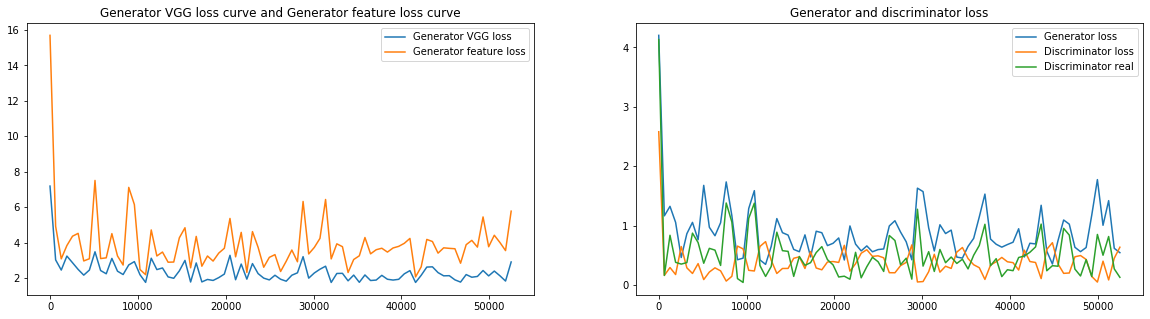

In [38]:
#Visualizing Train loss
#Initial error G_GAN_Feat: 15.700 D_real: 4.131 G_GAN: 4.203 G_VGG: 7.186 D_fake: 2.581 
G_gan_feat = [15.7]
G_gan = [4.203]
D_fake = [2.581]
D_real = [4.131]
G_vgg = [7.186]
iters = [0]
with open("./checkpoints/Pose_Game/loss_log.txt") as fp:
    line = fp.readline()
    cnt = 1
    while line:
        if "G_GAN_Feat:" in line.split():
            A = line.split()
            G_gan_feat.append(float(A[7]))
            G_vgg.append(float(A[9]))
            G_gan.append(float(A[11]))
            D_fake.append(float(A[13]))
            D_real.append(float(A[15]))
            iters.append(dataset_size*(int(A[1][:-1])-1) + int(A[3][:-1])) 
        line = fp.readline()
        cnt += 1
#Plotting
plt.figure(figsize = [20,5])
plt.subplot(1,2,1)
plt.title("Generator VGG loss curve and Generator feature loss curve")
plt.plot(iters,G_vgg)
plt.plot(iters,G_gan_feat)
plt.legend(["Generator VGG loss","Generator feature loss"])
plt.subplot(1,2,2)
plt.title("Generator and discriminator loss")
plt.plot(iters,G_gan)
plt.plot(iters,D_fake)
plt.plot(iters,D_real)
plt.legend(["Generator loss","Discriminator loss","Discriminator real"])
plt.show()